## Setup

In [29]:
import pandas as pd
import epipi
import matplotlib.pyplot as plt
import arviz as az
import numpy as np
import branchpro
import scipy.stats
from branchpro.apps import ReproductionNumberPlot
import plotly.graph_objs as go

# Data Preparation
omega = pd.read_csv('./PCR_curve_summary.csv')['median'].values
omega_pos_list = np.arange(1, 31) * 10
omega = omega[omega_pos_list]
theta = pd.read_csv('../EpiOS/y_interpolated.csv')['y_interpolated'].values
theta_true = pd.read_csv('../EpiOS/true_infection.csv')['True'].values
theta = theta_true
incidences_true = pd.read_csv('../EpiOS/incidences_true.csv')['incidences_true'].values

## Use PyStan with kernel at the end of time sample

In [ ]:
prior = []
for i in range(len(theta)):
    prior.append(epipi.NormalPrior(1000, 200))
prior.append(epipi.NormalPrior(0, 1))

In [30]:
# theta = theta_true
kernel = [0, 0, 0]
starting_time_point = 0
end_time_point = len(theta)
init_infection = 100
controller = epipi.InferenceController(theta[starting_time_point:end_time_point], omega, kernel=kernel)
fit, samples = controller.run()
df = az.summary(samples)
df

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 28: Argument
    1700 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 22: Argument
    5000 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  16% (

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
I[0],193.398,14.563,164.641,218.298,0.204,0.144,5562.0,2818.0,1.0
I[1],15.790,14.392,0.005,41.905,0.228,0.183,3933.0,2430.0,1.0
I[2],30.347,22.033,0.011,68.510,0.331,0.238,3574.0,2216.0,1.0
I[3],71.122,35.950,0.001,127.834,0.658,0.465,2447.0,1194.0,1.0
I[4],95.831,43.277,12.383,170.265,0.765,0.541,3058.0,1575.0,1.0
...,...,...,...,...,...,...,...,...,...
I[78],4.095,3.755,0.008,10.984,0.043,0.037,5172.0,2100.0,1.0
I[79],4.580,4.146,0.003,12.221,0.052,0.047,5012.0,2323.0,1.0
I[80],5.556,4.970,0.006,14.609,0.057,0.049,5344.0,2361.0,1.0
I[81],8.685,7.469,0.003,21.952,0.090,0.073,4715.0,2502.0,1.0


Mean R_hat is 1.0
Std R_hat is 0.0


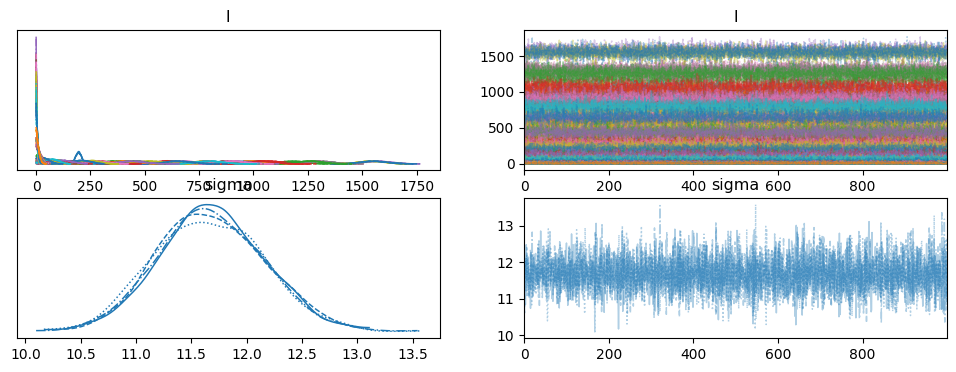

In [31]:
az.plot_trace(samples)
print('Mean R_hat is', df['r_hat'].values.mean())
print('Std R_hat is', df['r_hat'].values.std())

In [32]:
pre_I = np.array(list(df['mean'].values[:-1]) + kernel)
pre_std = np.array(list(df['sd'].values[:-1]) + kernel)

figure = go.Figure()

trace1 = go.Scatter(
    y=pre_I,
    x=list(range(starting_time_point, end_time_point)),
    mode='lines',
    name='Estimated Incidences',
    line_color='indigo'
)

trace2 = go.Scatter(
    x=list(range(starting_time_point, end_time_point)) + list(range(starting_time_point, end_time_point))[::-1],
    y=(pre_I + 1.96 * pre_std).tolist() + (pre_I - 1.96 * pre_std).tolist()[::-1],
    fill='toself',
    fillcolor='indigo',
    line_color='indigo',
    opacity=0.5,
    mode='lines',
    name='Credible interval 0.95',
)

trace3 = go.Scatter(
    y=incidences_true,
    x=list(range(starting_time_point, end_time_point)),
    mode='lines',
    name='Actual Incidences',
    line_color='green'
)

figure.add_trace(trace1)
figure.add_trace(trace2)
figure.add_trace(trace3)

In [5]:
incidences_true

array([0.000e+00, 0.000e+00, 1.420e+02, 1.580e+02, 7.500e+01, 1.440e+02,
       9.800e+01, 1.290e+02, 2.480e+02, 3.130e+02, 2.480e+02, 4.010e+02,
       3.500e+02, 5.160e+02, 5.290e+02, 7.180e+02, 6.220e+02, 9.740e+02,
       6.790e+02, 1.117e+03, 1.039e+03, 8.850e+02, 8.660e+02, 1.524e+03,
       1.502e+03, 1.596e+03, 1.208e+03, 1.267e+03, 1.104e+03, 1.200e+03,
       1.318e+03, 1.002e+03, 1.225e+03, 8.280e+02, 8.810e+02, 7.010e+02,
       5.650e+02, 6.810e+02, 5.550e+02, 3.890e+02, 2.950e+02, 2.810e+02,
       2.480e+02, 2.760e+02, 1.580e+02, 1.110e+02, 9.700e+01, 8.200e+01,
       9.500e+01, 5.000e+01, 5.600e+01, 3.800e+01, 4.000e+01, 2.900e+01,
       1.900e+01, 1.400e+01, 1.200e+01, 1.300e+01, 2.000e+01, 8.000e+00,
       1.100e+01, 7.000e+00, 3.000e+00, 6.000e+00, 0.000e+00, 1.000e+00,
       5.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 

Problems: How to deal with the value of I[0]? There have to be some initial patients, the model will still generate an estimate of the inital "true" infection based on the model. What about just manually set that value to 0 or leave it there for users to interpret that?

Idea: May redefine the model, add a 'I[-1]' to deal with the initial patients?

## Predict $R_t$

In [23]:
# Define variables needed for calculating R_t
tau = 6
R_t_start = tau+1
a = 1
b = 1/5

ws_mean = 4
ws_var = 3**2
theta_num = ws_var / ws_mean
k = ws_mean / theta_num
w_dist = scipy.stats.gamma(k, scale=theta_num)
disc_w = w_dist.pdf(range(len(theta)))
serial_interval = disc_w

In [41]:
# Plot comparison between the true and predicted R_t
# Transform our incidence data into pandas dataframes
inc_data = pd.DataFrame(
    {
        'Time': np.arange(len(theta)),
        'Incidence Number': pre_I
    }
)

inference = branchpro.BranchProPosterior(
    inc_data=inc_data,
    daily_serial_interval=serial_interval,
    alpha=a,
    beta=1/b)

inference.run_inference(tau=tau)
intervals = inference.get_intervals(central_prob=.95)

# Transform our true incidence data into pandas dataframes
inc_data_true = pd.DataFrame(
    {
        'Time': np.arange(len(theta)),
        'Incidence Number': incidences_true[:len(theta)]
    }
)

inference_true = branchpro.BranchProPosterior(
    inc_data=inc_data_true,
    daily_serial_interval=serial_interval,
    alpha=a,
    beta=1/b)

inference_true.run_inference(tau=tau)
intervals_true = inference_true.get_intervals(central_prob=.95)

fig = ReproductionNumberPlot()

fig.add_interval_true_rt(intervals_true)
fig.add_interval_rt(intervals)

fig.update_labels(time_label='Time (Day)', r_label='R_t')

fig.show_figure()

ValueError: All arrays must be of the same length

To do list: Write a SnakeMake file to install PyStan on Apple Silicon